# Problem Definition
In this assignment I will try to optimise a Neural Network to solve a regression problem.  
The dataset can be found here: https://www.kaggle.com/datasets/ashydv/advertising-dataset. Since Neural Network optimisation is a complicated process as the dimensions of the problem are directly proportional to the number of nodes in the network, hence I have chosen a simple dataset. Our task is to optimise a neural network to reduce the regression loss on the training dataset and we will verify our results by finding out the loss on the test dataset as well. We will use the test dataset as a metric to compare our two meta heuristic algorithms.  
My experiment log can be found here: https://wandb.ai/piperunner/ntnu-si-assignment-3  
My experiment report can be found here: https://wandb.ai/piperunner/ntnu-si-assignment-3/reports/NTNU-SI-Assignment-3--VmlldzoyOTIxMDEy  
Github: https://github.com/Pipe-Runner/ntnu-si-assignment-3

The problem has the following characteristics:
1. ℝ^n search space where n is the number of weights in our Neural Network
2. Continuous
3. Since our problem is time invariant, it's a static optimisation problem

---

# Setup
We will load all the necessary libraries.

In [17]:
from sklearn import datasets
import pandas as pd
import numpy as np
import math
import random
from numpy_ml import neural_nets
import plotly.express as px
import plotly.graph_objects as go
import os
from pathlib import Path

DATA_DIR = Path("../data")
data = pd.read_csv(DATA_DIR / "advertising.csv")

# Data

In this experiment, we'll be using the Iris dataset. The iris dataset has 150 entries, each of them having four attributes. There are no missing values in the dataset, and each data entry maps one of the three possible classes.
1. Iris Setosa
2. Iris Versicolour
3. Iris Versicolour

In [18]:
split = 0.8
train = data.sample(frac=0.8)
test = data.drop(train.index).reset_index(drop=True)

(x_train, y_train) = (train[["TV", "Radio", "Newspaper"]], train[["Sales"]])
(x_test, y_test) = (test[["TV", "Radio", "Newspaper"]], test[["Sales"]])

# Neural Network
In this section, we'll be defining the neural network that we will be using for our experiment.

## Utility functions

In [19]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def ReLU(x):
    return np.maximum(0,x)

def dReLU(x):
    return 1 * (x > 0) 

def softmax(z):
    z = z - np.max(z, axis = 1).reshape(z.shape[0],1)
    return np.exp(z) / np.sum(np.exp(z), axis = 1).reshape(z.shape[0],1)

def stable_softmax(z):
    exps = np.exp(z - np.max(z))
    return exps / np.sum(exps)

## The Neural Network
Note: We are using ReLU activation

In [20]:
class NN:
    def __init__(self, input_size, output_size, hidden_shape, act_fn = ReLU):
        self.nodes = hidden_shape
        self.params = []
        self.biases = []
        self.total_num_params = 0
        self.act_fn = act_fn

        assert len(hidden_shape) > 0
        assert input_size > 0
        assert output_size > 0

        # Creating the network
        nn_last_layer_size = None
        for hidden_size in hidden_shape:
            nn_in_size = input_size if nn_last_layer_size is None else nn_last_layer_size
            nn_out_size = hidden_size
            
            self.params.append(np.random.randn(nn_in_size, nn_out_size))
            self.biases.append(np.random.randn(nn_out_size,))

            nn_last_layer_size = nn_out_size

            # storing dims for later
            self.total_num_params += (nn_in_size * nn_out_size) + nn_out_size

        self.params.append(np.random.rand(nn_last_layer_size, output_size))
        self.biases.append(np.random.randn(output_size,))

        # storing dims for later
        self.total_num_params += (nn_last_layer_size * output_size) + output_size

    def forward(self, data):
        nn_intermediate_output = data

        for hidden_layer, bias in zip(self.params, self.biases):
            nn_intermediate_output = self.act_fn(np.dot(nn_intermediate_output, hidden_layer) + bias)
        
        return nn_intermediate_output

    """
    This function converts all the weights into a single dimension array
    which allows for algorithms to operate of weights on the NN directly
    """
    def export(self):
        output = np.array([])
        for idx in range(len(self.params)):
            output = np.concatenate((output, self.params[idx].flatten()), axis=None)

        for idx in range(len(self.biases)):
            output = np.concatenate((output, self.biases[idx].flatten()), axis=None)

        return output

    """
    This function loads a single dimension array into weights and biases.
    We first load weights and then load biases
    """
    def load(self, arr):
        assert self.total_num_params == len(arr)
        
        start_idx = 0
        for idx in range(len(self.params)):
            dim_1 = self.params[idx].shape[0]
            dim_2 = self.params[idx].shape[1]
            end_idx = start_idx + (dim_1 * dim_2)
            self.params[idx] = np.array(arr[start_idx:end_idx]).reshape(dim_1, dim_2)

            start_idx = end_idx

        for idx in range(len(self.biases)):
            dim_1 = self.biases[idx].shape[0]
            end_idx = start_idx + dim_1
            self.biases[idx] = np.array(arr[start_idx:end_idx]).reshape(dim_1,)

            start_idx = end_idx        

I'll quickly test the network here to make sure it works as expected.

In [21]:
dummy_nn = NN(x_train.shape[1], 1, [4, 3])

# Testing with two data points
sample_train_data = x_train[:2]

# Testing a forward pass
dummy_nn.forward(sample_train_data)

# Testing export
assert len(dummy_nn.export()) == 35

# Testing weights loading
dummy_nn.load(np.array([x for x in range(35)]))

## Loss Function
I am using Mean Squared Error as my cost function which is pretty standard for regression problems. The equation of the function looks like this:  
L( y, y^) = (0.5 * |y^−y|^2) / m  
Here m is the number of points
https://numpy-ml.readthedocs.io/en/latest/numpy_ml.neural_nets.losses.html#squarederror

In [22]:
loss_instance = neural_nets.losses.SquaredError()

# MSE
def loss(pred, target):
    m = pred.shape[0]
    return loss_instance.loss(target, pred) / m

I'll quickly test if the loss function works as expected

In [23]:
sample_train_label = y_train[:10]
sample_train_data = x_train[:10]

test_nn = NN(x_train.shape[1], 1, [4, 3])
pred = test_nn.forward(sample_train_data)

# Expected to have high loss
print(loss(pred, sample_train_label))

# Expected to have low loss
print(loss(sample_train_label, sample_train_label))

115.60435561536947
0.0


## Helper function for plotting

In [24]:
def plot_loss(ep_cost):
    fig = px.line(
        ep_cost, 
        y="least_cost", 
        x="epoch", 
        labels={
            "least_cost": "Cost"
        },
        height=600,
        markers=False,
        title="Loss vs Epoch", 
    )
    fig.layout.template = "plotly_dark"
    fig.update_xaxes(
        tickangle = -45,
    )
    fig.show()
    
def plot_tv(nn):
    train_copy = train.copy()
    train_copy = train_copy.sort_values(by=["TV"])

    points = np.linspace(x_train["TV"].min(), x_train["TV"].max(), num=1000)
    points_df = pd.DataFrame({"TV": points, "Radio": train_copy["Radio"].mean(), "Newspaper": train_copy["Newspaper"].mean()})
    points_df["Sales Pred"] = nn.forward(points_df)
    # train_copy["Sales Pred"] = nn.forward(train_copy[["TV", "Radio", "Newspaper"]])
    
    fig = go.Figure([
        go.Scatter(x=train_copy['TV'], y=train_copy['Sales'], line=go.scatter.Line(dash="dot", width=1, color="blue"), mode="markers"),
        go.Scatter(x=points_df['TV'], y=points_df["Sales Pred"], line=go.scatter.Line(dash="solid", width=1, color="yellow", shape="spline"))
    ])
    fig.layout.template = "plotly_dark"
    fig.update_layout(
        title = dict(
            font = dict(
                size = 20
            ),
            text = "Sales vs TV Ads"
        ),
        height = 600,
        yaxis_title="Sales",
        xaxis_title="TV Ads"
    )
    fig.update_xaxes(
        tickangle = -45,
    )
    fig.update_layout(title_x=0.5)
    fig.show()
    
def plot_radio(nn):
    train_copy = train.copy()
    train_copy = train_copy.sort_values(by=["Radio"])

    points = np.linspace(x_train["Radio"].min(), x_train["Radio"].max(), num=1000)
    points_df = pd.DataFrame({"TV": train_copy["TV"].mean(), "Radio": points, "Newspaper": train_copy["Newspaper"].mean()})
    points_df["Sales Pred"] = nn.forward(points_df)
    # train_copy["Sales Pred"] = nn.forward(train_copy[["TV", "Radio", "Newspaper"]])
    
    fig = go.Figure([
        go.Scatter(x=train_copy['Radio'], y=train_copy['Sales'], line=go.scatter.Line(dash="dot", width=1, color="blue"), mode="markers"),
        go.Scatter(x=points_df['Radio'], y=points_df["Sales Pred"], line=go.scatter.Line(dash="solid", width=1, color="yellow", shape="spline"))
    ])
    fig.layout.template = "plotly_dark"
    fig.update_layout(
        title = dict(
            font = dict(
                size = 20
            ),
            text = "Sales vs Radio Ads"
        ),
        height = 600,
        yaxis_title="Sales",
        xaxis_title="Radio Ads"
    )
    fig.update_xaxes(
        tickangle = -45,
    )
    fig.update_layout(title_x=0.5)
    fig.show()
    
def plot_newspaper(nn):
    train_copy = train.copy()
    train_copy = train_copy.sort_values(by=["Newspaper"])

    points = np.linspace(x_train["Newspaper"].min(), x_train["Newspaper"].max(), num=1000)
    points_df = pd.DataFrame({"TV": train_copy["TV"].mean(), "Radio": train_copy["Radio"].mean(), "Newspaper": points})
    points_df["Sales Pred"] = nn.forward(points_df)
    # train_copy["Sales Pred"] = nn.forward(train_copy[["TV", "Radio", "Newspaper"]])
    
    fig = go.Figure([
        go.Scatter(x=train_copy['Newspaper'], y=train_copy['Sales'], line=go.scatter.Line(dash="dot", width=1, color="blue"), mode="markers"),
        go.Scatter(x=points_df['Newspaper'], y=points_df["Sales Pred"], line=go.scatter.Line(dash="solid", width=1, color="yellow", shape="spline"))
    ])
    fig.layout.template = "plotly_dark"
    fig.update_layout(
        title = dict(
            font = dict(
                size = 20
            ),
            text = "Sales vs Newspaper Ads"
        ),
        height = 600,
        yaxis_title="Sales",
        xaxis_title="Newspaper Ads"
    )
    fig.update_xaxes(
        tickangle = -45,
    )
    fig.update_layout(title_x=0.5)
    fig.show()

# Optimisation

In the following section, we will be optimising the neural network using methods like:
1. Particle Swarm Optimisation
2. Ant Colony Optimisation

## Particle Swarm Optimisation

In [25]:
class Particles:
    def __init__(self, idx, position, velocity, initial_cost):
        self.pid = idx
        self.position = position
        self.velocity = velocity
        self.best_position = position
        self.least_cost = initial_cost
    
class NN_PSO:
    def __init__(self, nn, particle_count, data_x, data_y, config={}):
        search_space_dims = len(nn.export())

        self.nn = nn
        self.data_x = data_x
        self.data_y = data_y
        self.best_position = None
        self.best_accuracy = None
        self.least_cost = math.inf
        self.config = config

        # Create particles with random position
        assert particle_count > 0
        self.particles = []
        max_nodes = max(nn.nodes)
        std = math.sqrt(2.0 / max_nodes)
        mean = 0
        for idx in range(particle_count):
            position = np.random.randn(search_space_dims,) * std + mean
            velocity = None
            cost = self.__cost(position)

            if cost < self.least_cost:
                self.least_cost = cost
                self.best_position = position

            particle = Particles(
                idx,
                position, 
                velocity,
                cost,
                # acc
            )
            self.particles.append(particle)

    def __cost(self, position):
        self.nn.load(position)
        pred = self.nn.forward(self.data_x)

        return loss(pred, self.data_y)

    def fit(self, epochs = 10, dt=0.01):
        ep_cost = pd.DataFrame(columns=["epoch", "least_cost"]) 
        i_start = self.config["inertia_start"]
        i_end = self.config["inertia_end"]
        c_1 = self.config["c_1"]
        c_2 = self.config["c_2"]

        for epoch_idx in range(epochs):
            w = i_start - (i_start - i_end) * (epoch_idx / epochs)

            for particle in self.particles:
                r_1 = random.random()
                r_2 = random.random()

                new_vel = np.add(
                    (particle.best_position - particle.position) * (r_1 * c_2),
                    (self.best_position - particle.position) * (r_2 * c_2)
                )
                new_pos = np.add(
                    particle.position,
                    new_vel * dt
                )

                particle.velocity = new_vel
                particle.position = new_pos

                cost = self.__cost(new_pos)

                if cost < particle.least_cost:
                    particle.least_cost = cost
                    particle.best_position = new_pos

                if cost < self.least_cost:
                    self.least_cost = cost
                    self.best_position = new_pos
        
            ep_cost.loc[len(ep_cost.index)] = [epoch_idx, self.least_cost]
            
        # loggin test loss
        self.nn.load(self.best_position)
        pred = self.nn.forward(x_test)

        return (self.best_position, self.least_cost, ep_cost)

## Bat Algorithm
A bit of literature on BA: 
- https://arxiv.org/pdf/1308.3900.pdf
- https://www.researchgate.net/publication/343260624_A_critical_analysis_of_the_bat_algorithm
- https://medium.com/swlh/nature-inspired-optimization-algorithms-part-5-bats-algorithm-e839ac8b1830

In [26]:
class Bat:
    def __init__(self, pos, vel, freq, cost):
        self.pos = pos
        self.vel = vel
        self.freq = freq
        self.least_cost = cost

class NN_BA:
    def __init__(self, nn, bat_count, amp, freq, freq_min, freq_max, data_x, data_y,):
        self.nn = nn
        self.data_x = data_x
        self.data_y = data_y
        

        self.search_space_dims = len(nn.export())
        self.bat_count = bat_count
        self.amp = amp # [0, 1)
        self.freq = freq # [0, 1)
        self.freq_min = freq_min
        self.freq_max = freq_max

        self.least_cost = math.inf
        self.best_position = None
        
        self.bats = []
        
        max_nodes = max(nn.nodes)
        std = math.sqrt(2.0 / max_nodes)
        mean = 0
        for idx in range(bat_count):
            position = np.random.randn(self.search_space_dims,) * std + mean
            velocity = np.zeros(self.search_space_dims,) # should be zero?
            cost = self.__cost(position)
            bat = Bat(position, velocity, 0, cost) # freq gets updated on the first run itself
            self.bats.append(bat)
            
            if cost < self.least_cost:
                self.least_cost = cost
                self.best_position = position
    
    def __cost(self, position):
        self.nn.load(position)
        pred = self.nn.forward(self.data_x)

        return loss(pred, self.data_y)
    
    def fit(self, epochs):
        ep_cost = pd.DataFrame(columns=["epoch", "least_cost"])
        
        for epoch_idx in range(epochs):
            for bat in self.bats:
                beta = np.random.uniform(0, 1)
                bat.freq = self.freq_min + (self.freq_max - self.freq_min) * beta # update freq
                bat.vel = bat.vel + (bat.pos - self.best_position) * bat.freq # velocity update
                temp_pos = bat.pos + bat.vel
                
                rnd = np.random.random_sample()
                
                if rnd > self.freq:
                    temp_pos = self.best_position + np.random.randn(self.search_space_dims,) * 0.001
                    
                cost = self.__cost(temp_pos)
                
                rnd = np.random.random_sample()
                
                if cost < bat.least_cost and rnd < self.amp:
                    bat.pos = temp_pos
                    bat.least_cost = cost
                    
                if cost < self.least_cost:
                    self.best_position = temp_pos
                    self.least_cost = cost
                  
            ep_cost.loc[len(ep_cost.index)] = [epoch_idx, self.least_cost]
        
        # loggin test loss
        self.nn.load(self.best_position)
        pred = self.nn.forward(x_test)
        
        return (self.best_position, self.least_cost, ep_cost)

### Unoptimised network
Let's check how our network looks without any optimisation  
Note: Our network is a fully connected network so it is easy to calculate the number of parameters.

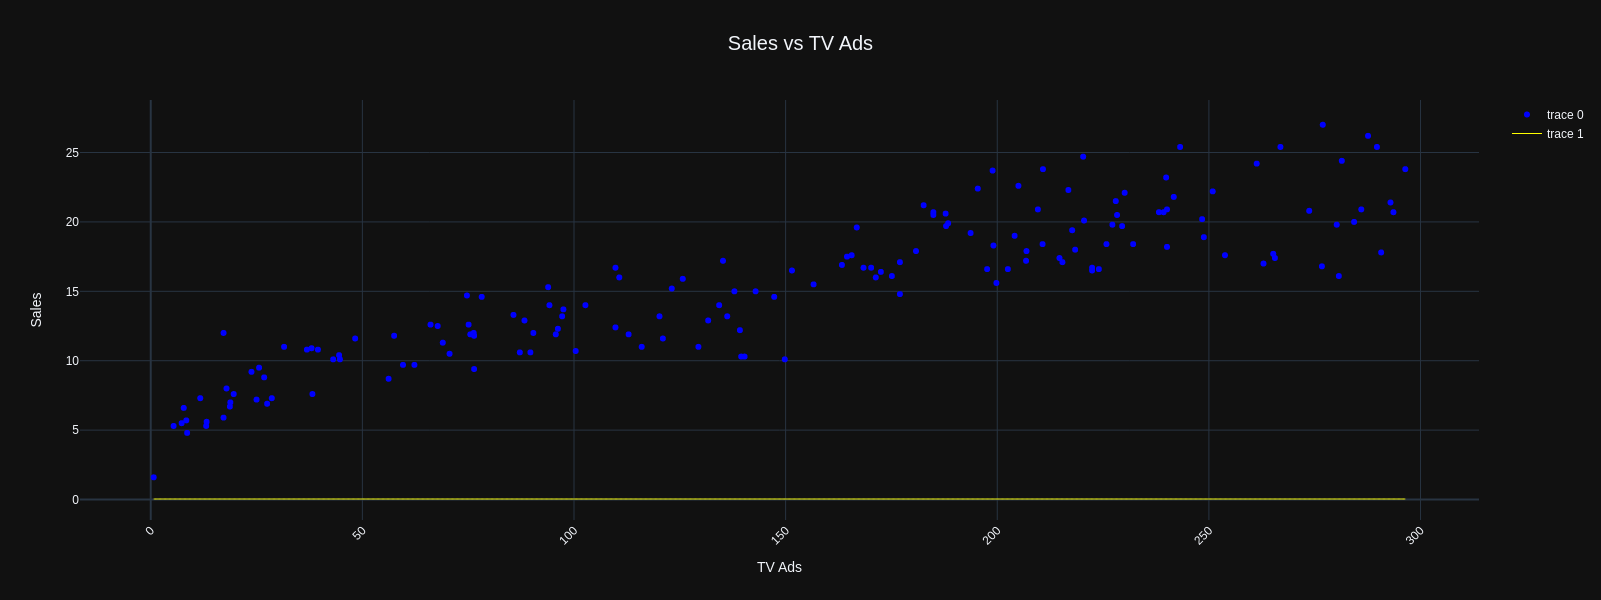

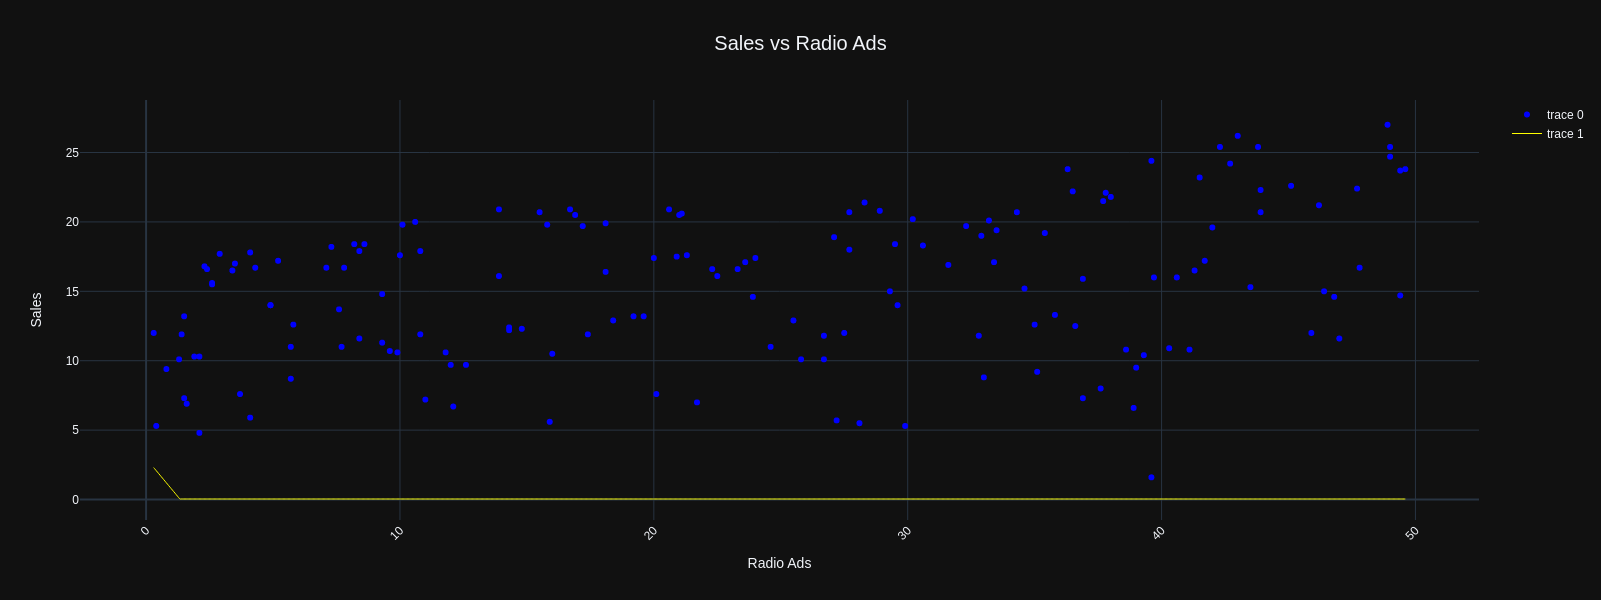

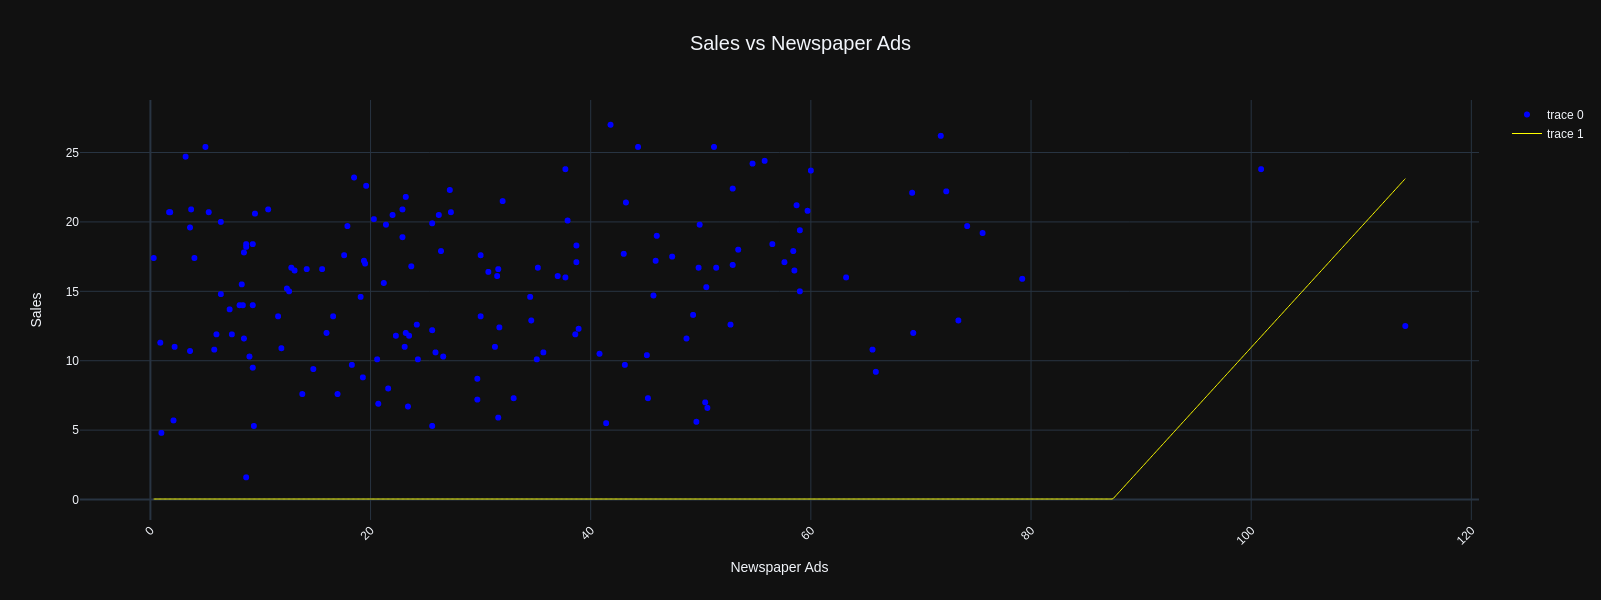

In [27]:
# Create neural network
nn = NN(x_train.shape[1], 1, [4, 3, 2])

plot_tv(nn)
plot_radio(nn)
plot_newspaper(nn)

### PSO Optmisation
Now we will try to optimise the network using PSO

5.195120408386467
2.8754274811744236


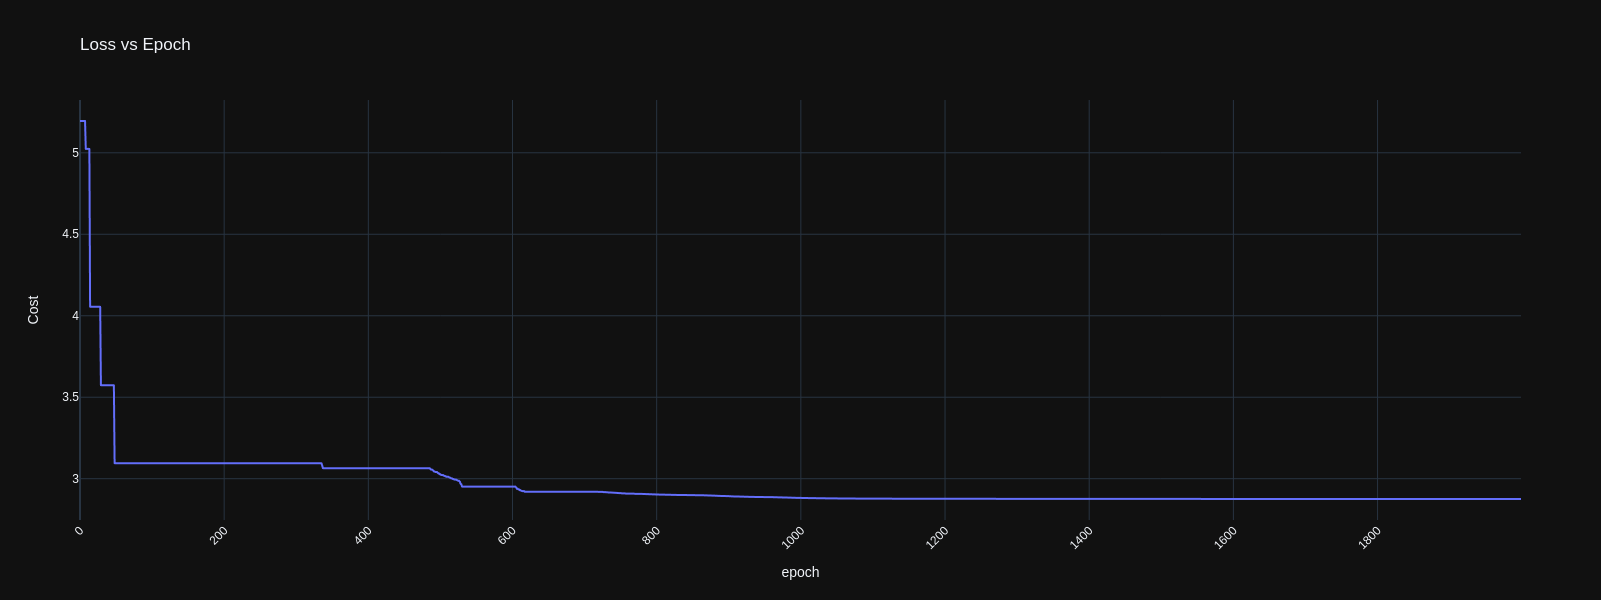

In [28]:
if True:
    nn_pso = NN_PSO(
        nn, 
        500,
        x_train, 
        y_train, 
        {
            "inertia_start": 1,
            "inertia_end": 0.8,
            "c_1": 1.5,
            "c_2": 1.1
        }
    )

    print(nn_pso.least_cost)

    (_, _, ep_cost) = nn_pso.fit(2000, 0.01)

    print(nn_pso.least_cost)
    plot_loss(ep_cost)

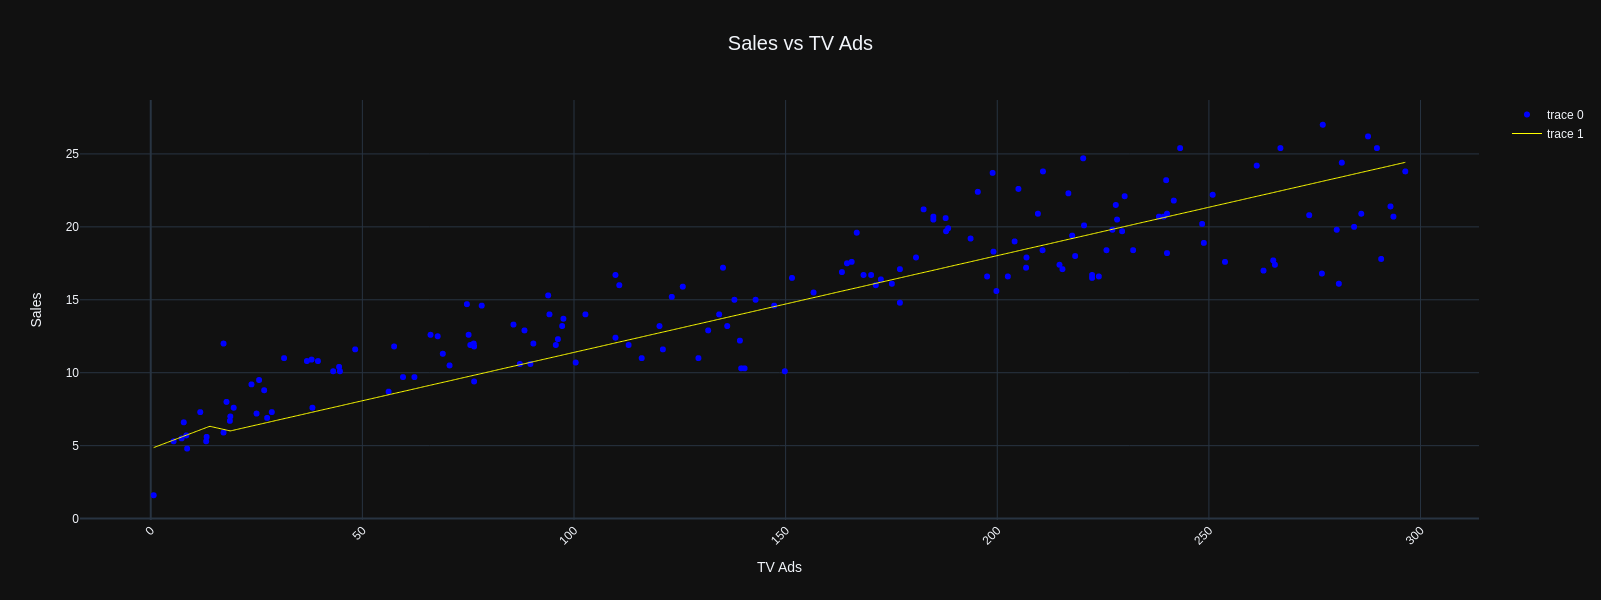

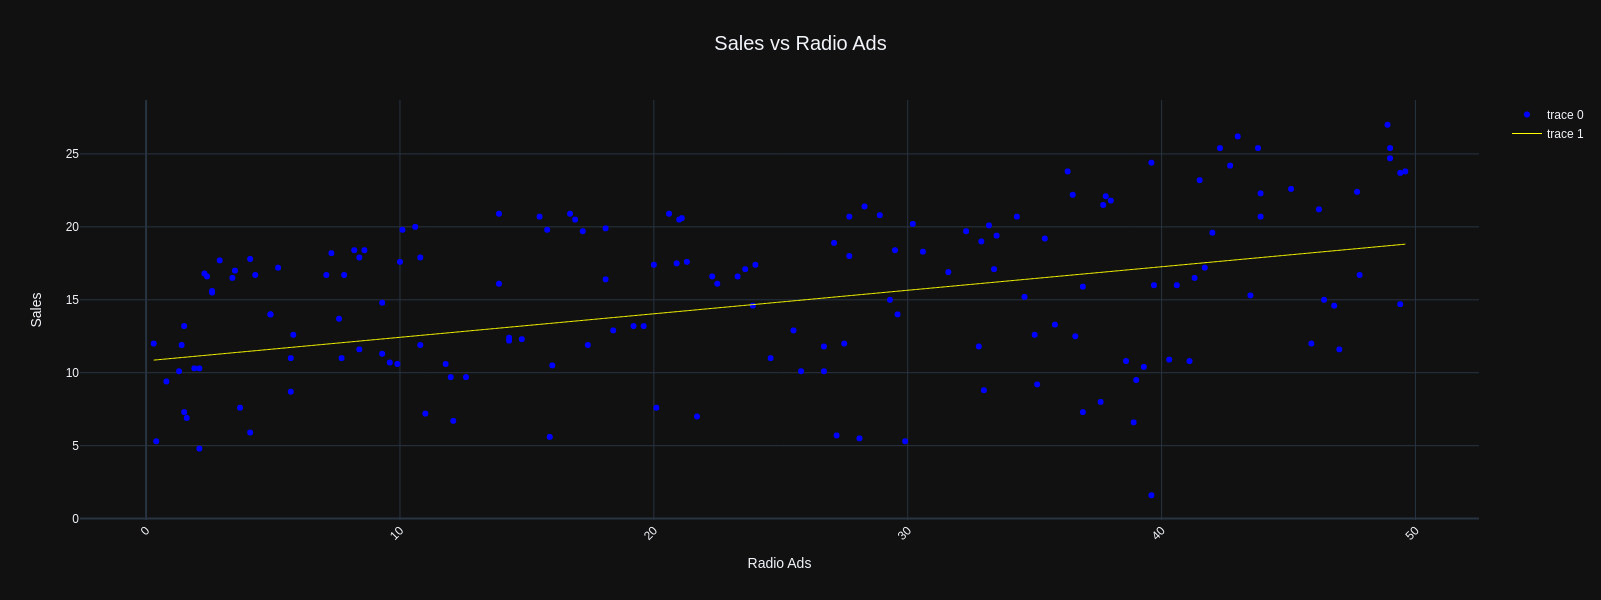

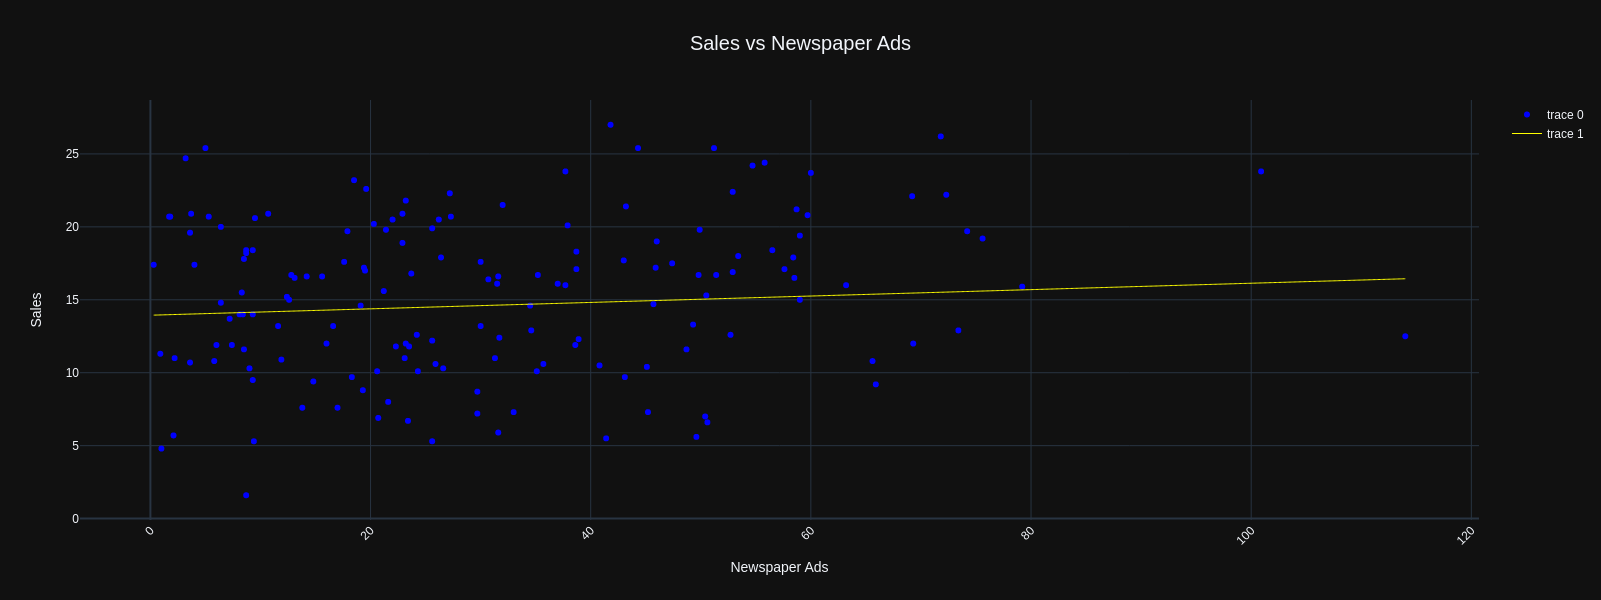

In [29]:
plot_tv(nn)
plot_radio(nn)
plot_newspaper(nn)

### BA Optmisation
Now we will try to optimise the network using BA

3.913850136493333
1.2588880898952457


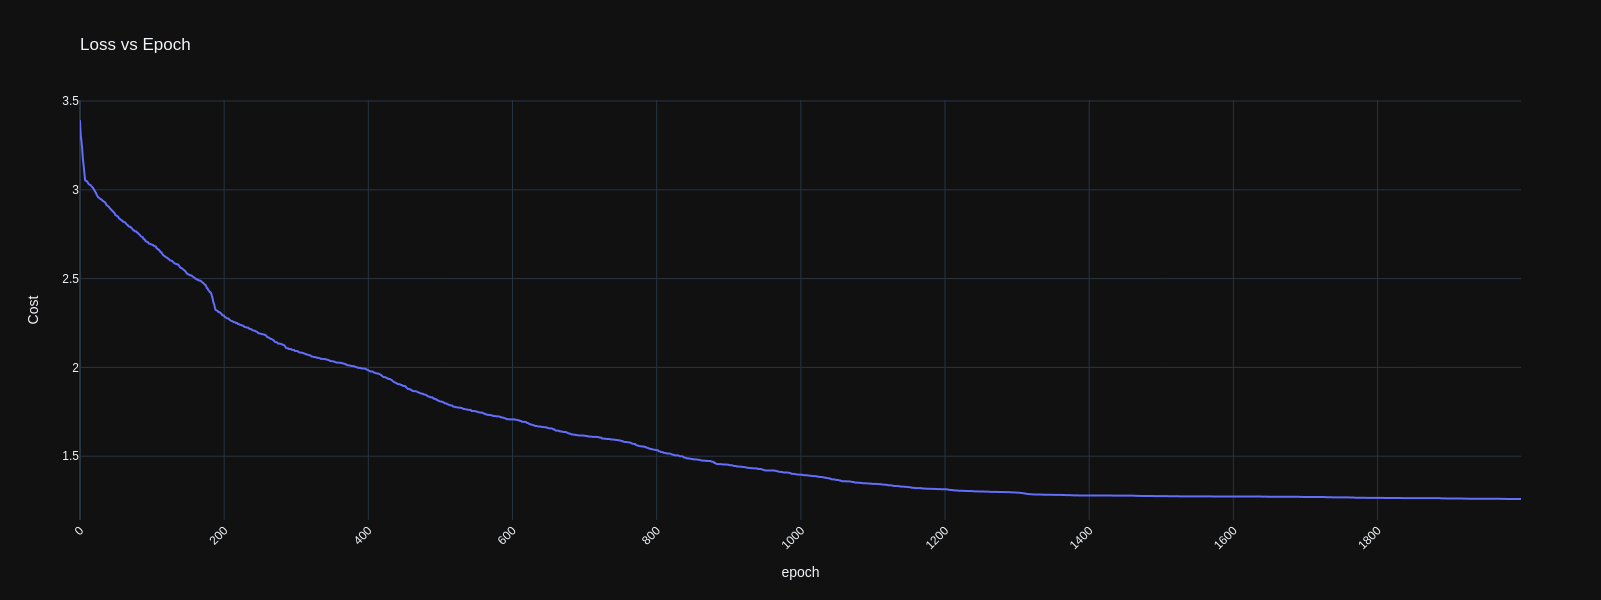

In [30]:
if True:
    # Create BA
    nn_ba = NN_BA(
        nn, 
        100,
        0.5, 
        0.6, 
        0,
        1,
        x_train, 
        y_train,
    )

    print(nn_ba.least_cost)

    (_, _, ep_cost) = nn_ba.fit(2000)

    print(nn_ba.least_cost)
    plot_loss(ep_cost)

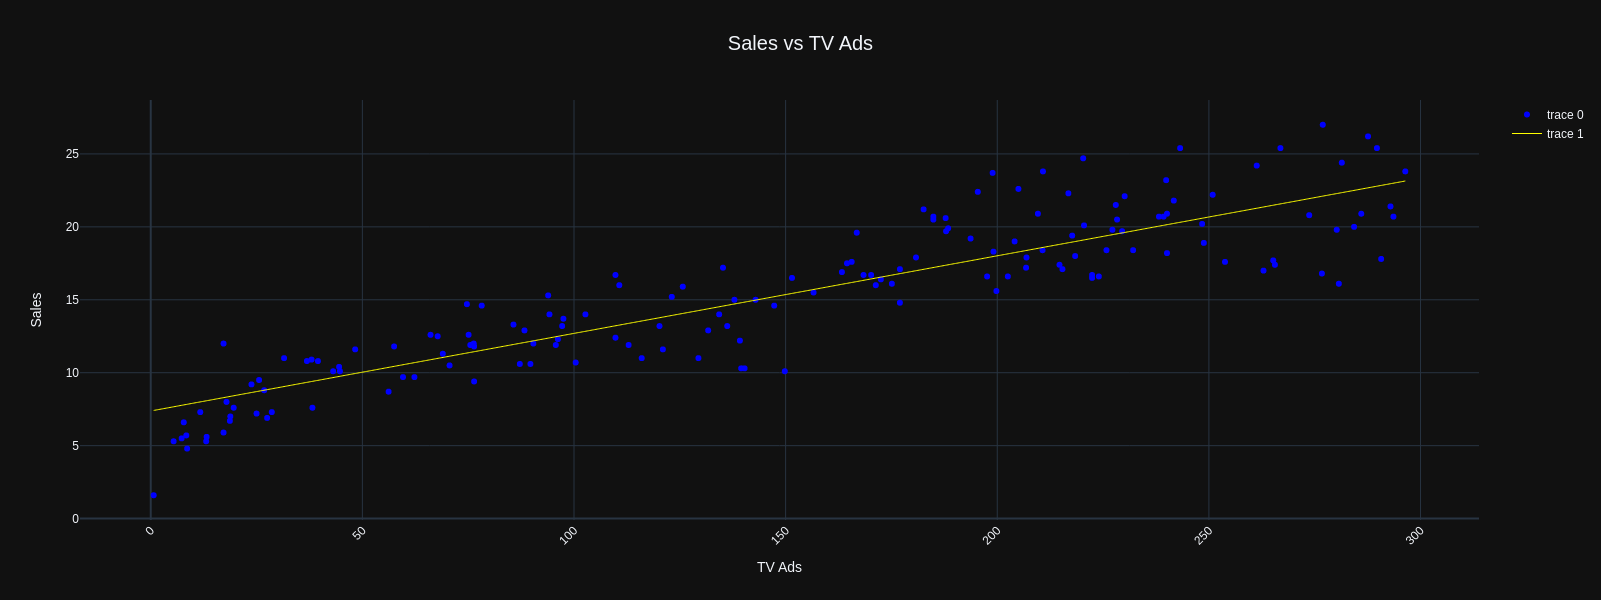

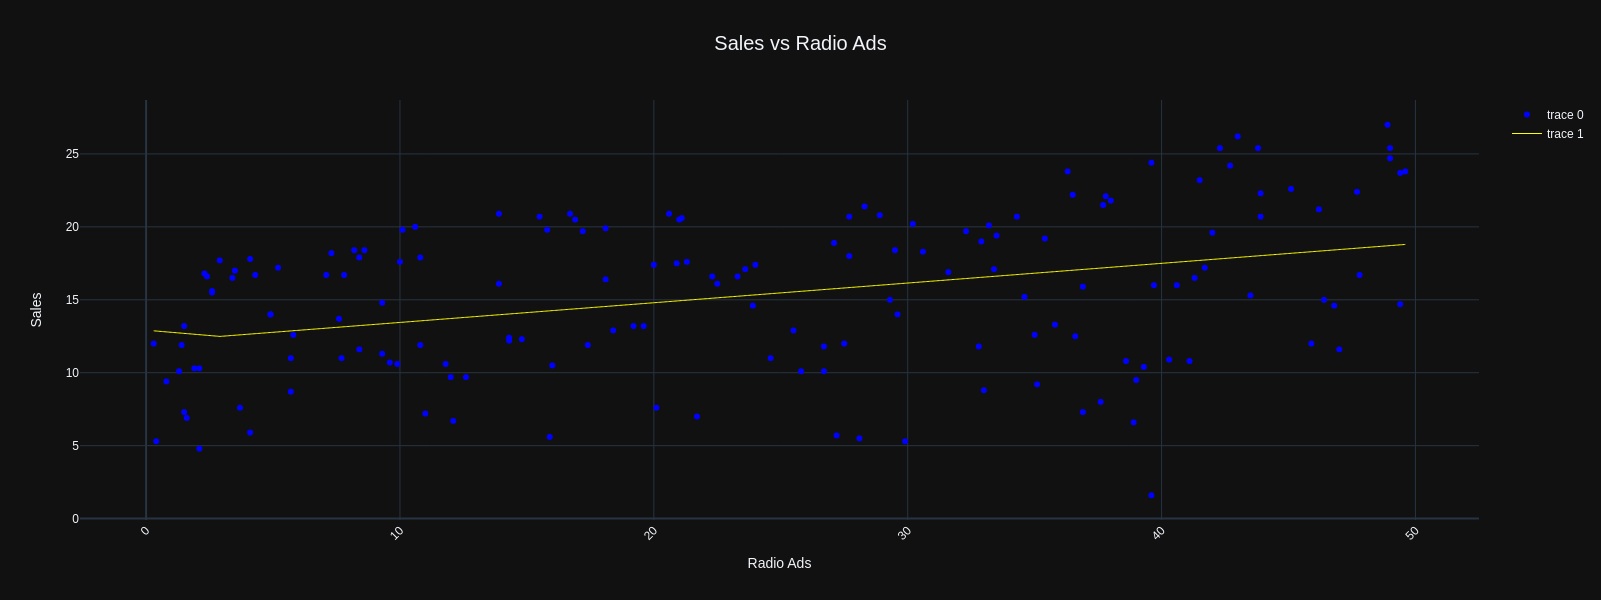

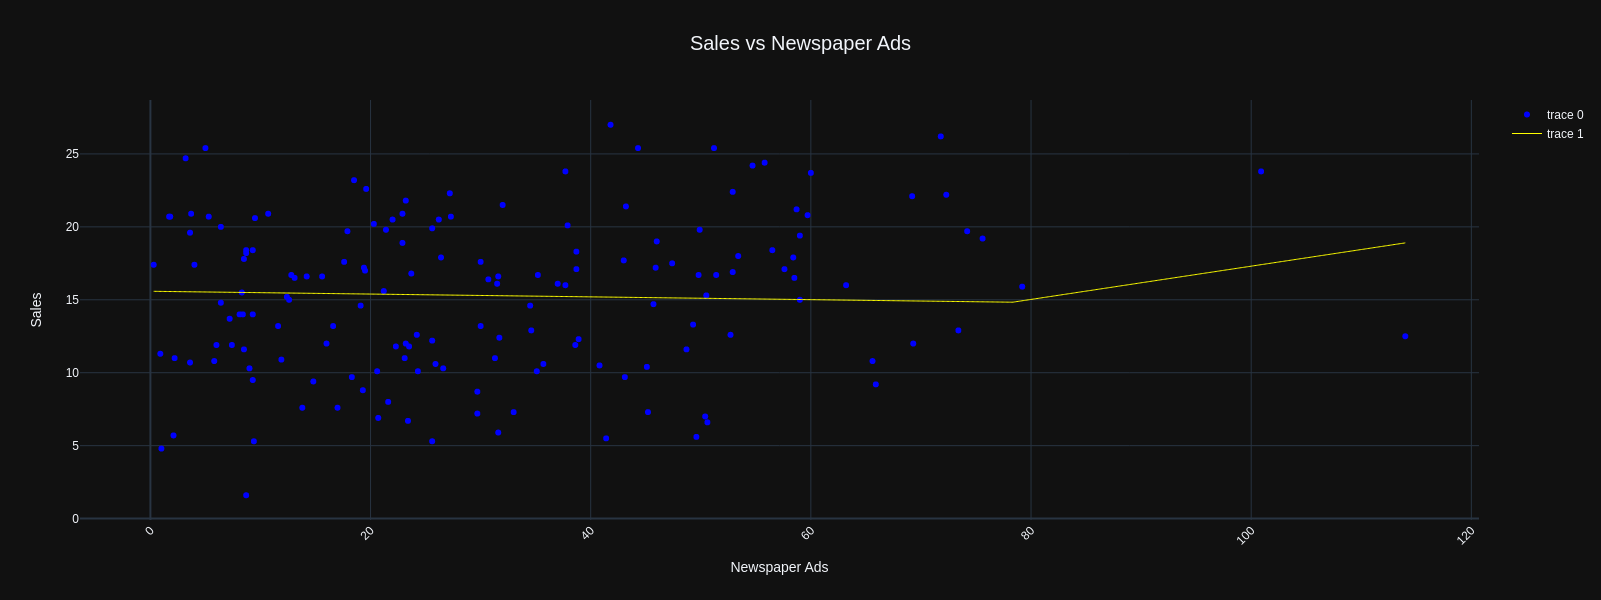

In [31]:
plot_tv(nn)
plot_radio(nn)
plot_newspaper(nn)